# We will use the donkeycar categorical method, which uses linear_bin & unbin to categorize the angles into their respective category.

# I am using GPU to speed up my code run time. 
# Delete this block if you do not need it 

In [4]:
import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# 1. Load packages and paste functions from donkeycar utils.py
# 2. Create lists to append angle, image array value and 1 hot encoded angle category. Use linear_bin to convert angles to 1 hot encoding

In [5]:
import os 
import numpy as np
import pandas as pd 
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import json
from matplotlib import image
import matplotlib.pyplot as plt
import numpy


def clamp(n, min, max):
    if n < min:
        return min
    if n > max:
        return max
    return n

def linear_bin(a, N=15, offset=1, R=2.0):
    '''
    create a bin of length N
    map val A to range R
    offset one hot bin by offset, commonly R/2
    '''
    a = a + offset
    b = round(a / (R/(N-offset)))
    arr = np.zeros(N)
    b = clamp(b, 0, N - 1)
    arr[int(b)] = 1
    return arr


def linear_unbin(arr, N=15, offset=-1, R=2.0):
    '''
    preform inverse linear_bin, taking
    one hot encoded arr, and get max value
    rescale given R range and offset
    '''
    b = np.argmax(arr)
    a = b *(R/(N + offset)) + offset
    return a


angle_results = []
image_list = []
encoded_category = []

filepath = "C:\\Users\\kansh\\projects\\mycar\\data\\tub_280_20-02-01\\" 
filenames = sorted(os.listdir(filepath), key=len)

for filename in filenames: 
    if filename.endswith(".json") and not filename.startswith("meta"):
            with open(filepath+filename, 'r') as read_file:
            
                json_data = json.load(read_file)                  
                x = float(json_data['user/angle'])
                
                angle_results.append(x)
                encoded_category.append(linear_bin(x))
                
    if filename.endswith(".jpg") and not filename.endswith(".json"):
        im=image.imread(filepath+filename)
        image_list.append(im)

print(angle_results[0:10])
print(encoded_category[0:10])
print(image_list[0:10])

[-0.02853175571986613, -0.02853175571986613, -0.03566480364118334, -0.07132960728236568, -0.06419655936104951, -0.04993068150111643, -0.04993068150111643, -0.02853175571986585, -0.01426587785993253, -0.014265877859933468]
[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])]
[array([[[ 42,  41,  11],
        [ 38,  37,   6],
        [ 40,  39,   8],
        ...

# 3. Convert image and 1 hot encoded lists into array, define as X and Y
# 4. Split them into X_train,X_test,Y_train,Y_test

In [6]:
array_image_list = np.array(image_list)
print(array_image_list.shape)

array_ec = np.array(encoded_category)
print(array_ec.shape)

(4917, 120, 160, 3)
(4917, 15)


In [12]:
X = array_image_list
Y = array_ec
X_train, X_test, Y_train , Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# 5. This model is taken from donkeycar's categorical architecture

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam

drop = 0.2
model = Sequential()
model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(120,160,3), name="conv2d_1"))    
model.add(Dropout(drop))                                                    
model.add(Conv2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2"))     
model.add(Dropout(drop))                                                   
    
model.add(Conv2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3"))     
model.add(Conv2D(64, (3,3), strides=(2,2), activation='relu', name="conv2d_4"))     

model.add(Dropout(drop))                                                   
model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5"))     
model.add(Dropout(drop))                                                    

model.add(Flatten(name='flattened'))                                
model.add(Dense(100, activation='relu', name="fc_1"))                                   
model.add(Dropout(drop))                                                     
model.add(Dense(50, activation='relu', name="fc_2"))                               
model.add(Dropout(drop))                                                    
model.add(Dense(15, activation='softmax'))

opt = Adam(lr=0.001,decay=0.0) 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 78, 24)        1824      
_________________________________________________________________
dropout_13 (Dropout)         (None, 58, 78, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 32)        19232     
_________________________________________________________________
dropout_14 (Dropout)         (None, 27, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 17, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 8, 64)          36928     
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 8, 64)          0         
__________

# 6. Use learn rate reduction to improve metric

In [39]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',  #val acc
                                            patience=1,  #5
                                            verbose=1, 
                                            mode='min',
                                            factor=0.2, 
                                            min_lr=0.001 
                                           ) 
callbacks = [learning_rate_reduction]

# 7. Run training

In [40]:
epochs = 100
batch_size = 128
steps = 100

history = model.fit(X_train, Y_train, epochs=epochs,validation_data=[X_test,Y_test], callbacks=callbacks)

Train on 3933 samples, validate on 984 samples
Epoch 1/100
3933/3933 [==============================] - 75s 19ms/step - loss: 3.1428 - acc: 0.1337 - val_loss: 2.5360 - val_acc: 0.1809
Epoch 2/100
3933/3933 [==============================] - 86s 22ms/step - loss: 2.4670 - acc: 0.1632 - val_loss: 2.3714 - val_acc: 0.1819
Epoch 3/100
3933/3933 [==============================] - 75s 19ms/step - loss: 2.3306 - acc: 0.2273 - val_loss: 2.2096 - val_acc: 0.2774
Epoch 4/100
3933/3933 [==============================] - 87s 22ms/step - loss: 2.1273 - acc: 0.2672 - val_loss: 1.9552 - val_acc: 0.3323
Epoch 5/100
3933/3933 [==============================] - 52s 13ms/step - loss: 2.0274 - acc: 0.2965 - val_loss: 1.8731 - val_acc: 0.3272
Epoch 6/100
3933/3933 [==============================] - 105s 27ms/step - loss: 1.9194 - acc: 0.3216 - val_loss: 1.8830 - val_acc: 0.3313

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 7/100
3933/3933 [==============================] - 85s 22ms

3933/3933 [==============================] - 89s 23ms/step - loss: 0.5851 - acc: 0.7971 - val_loss: 1.6703 - val_acc: 0.5528

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 88/100
3933/3933 [==============================] - 105s 27ms/step - loss: 0.5481 - acc: 0.8068 - val_loss: 1.7980 - val_acc: 0.5386

Epoch 00088: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 89/100
3933/3933 [==============================] - 103s 26ms/step - loss: 0.5867 - acc: 0.7996 - val_loss: 1.7124 - val_acc: 0.5528

Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 90/100
3933/3933 [==============================] - 69s 18ms/step - loss: 0.5471 - acc: 0.8098 - val_loss: 1.8525 - val_acc: 0.5467

Epoch 00090: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 91/100
3933/3933 [==============================] - 87s 22ms/step - loss: 0.5503 - acc: 0.8164 - val_loss: 1.7947 - val_acc: 0.5366

Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0

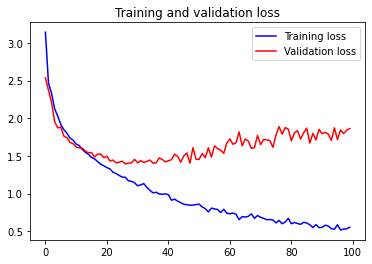

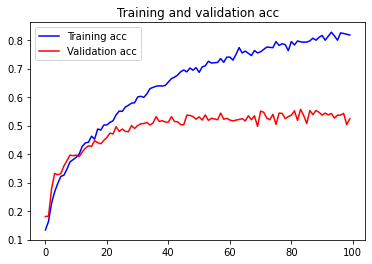

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation acc')
plt.legend(loc='best')

plt.show()

# 8. Save model and load
# 9. Get predictions

In [42]:
model.save('SavedModel5.hdf5')  # creates a HDF5 file 

In [8]:
from tensorflow import keras
from tensorflow.keras.models import load_model

# Load Saved Model
model = load_model('SavedModel5.hdf5', compile = False)

In [9]:
predictions = model.predict(array_image_list)
print(predictions[0:10])

[[7.0495513e-33 4.5959336e-34 2.4152303e-30 3.0922707e-25 1.9486693e-20
  3.4741381e-12 1.6740231e-06 9.9998927e-01 8.9644045e-06 1.2734901e-07
  5.9782007e-10 5.8940855e-15 5.4277642e-26 4.6454744e-37 0.0000000e+00]
 [1.0216674e-31 9.4689721e-33 2.2206931e-29 2.5325405e-24 1.2494526e-19
  1.0995279e-11 2.9519915e-06 9.9998641e-01 1.0341698e-05 2.2223959e-07
  1.1040915e-09 1.8907915e-14 5.2598336e-25 9.0598816e-36 0.0000000e+00]
 [2.3552077e-32 1.8207195e-33 7.5697789e-30 6.6169934e-25 4.6462447e-20
  5.1414151e-12 1.5605708e-06 9.9998629e-01 1.2056126e-05 1.6714266e-07
  7.9055895e-10 8.3406174e-15 8.4504518e-26 1.3284162e-36 0.0000000e+00]
 [9.4086133e-32 4.6300878e-33 1.4335058e-29 1.1438398e-24 7.6200137e-20
  6.2439862e-12 2.0516020e-06 9.9998844e-01 9.3135723e-06 1.9518275e-07
  1.0294779e-09 1.5015993e-14 3.9833398e-25 7.0210066e-36 0.0000000e+00]
 [6.3311138e-32 6.4188266e-33 1.3581577e-29 1.9424282e-24 8.1781324e-20
  7.8991258e-12 3.0534261e-06 9.9998772e-01 9.0775366e-06 1.

# 10. Use linear_unbin to decode the 1 hot encoded predictions 
# 11. Plot graph of original angle with predicted angle to compare prediction

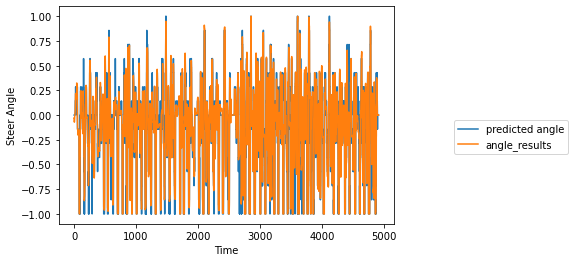

In [15]:
predicted_angle = []
for i in predictions:
    predicted_angle.append(linear_unbin(i))


plt.xlabel("Time")
plt.ylabel("Steer Angle")
plt.plot(predicted_angle, label='predicted angle')
plt.plot(angle_results, label='angle_results')
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
#plt.axis([0,1000,-1.1,1.1])
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

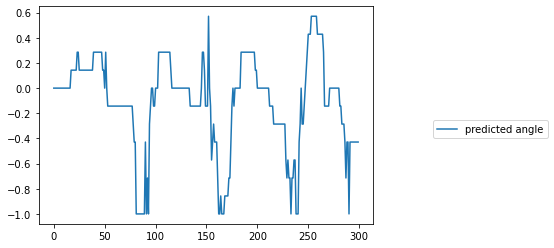

In [11]:
plt.plot(predicted_angle[0:300], label='predicted angle')
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
plt.show

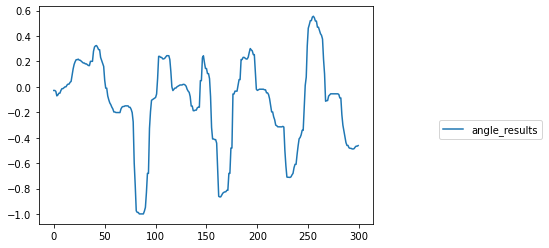

In [12]:
plt.plot(angle_results[0:300], label='angle_results')
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
plt.show()